# Simple MCTS
This notebook investigates using MCTS for a single static website where multiple actions have to be done to achieve an answer.

The task is to order a macbook with certain configurations. This website was chosen over others because it does not change upon selecting certain elements, which substantially simplifies testing as a website can simply be cached.

The start domain is [this page](https://www.apple.com/shop/buy-mac/macbook-pro/14-inch-space-gray-apple-m3-chip-with-8-core-cpu-and-10-core-gpu-8gb-memory-512gb) with the prompt "order a macbook pro 14 with 24 gb, 2 tb, fast charging and all available software"

Command to run this:
```
python run_demo.py --task_name openended --model_name openai/gpt-4o-mini --start_url https://www.apple.com/shop/buy-mac/macbook-pro/14-inch-space-gray-apple-m3-chip-with-8-core-cpu-and-10-core-gpu-8gb-memory-512gb
```

## Setup and load cached website

In [477]:
website = "https://www.apple.com/shop/buy-mac/macbook-pro/14-inch-space-gray-apple-m3-chip-with-8-core-cpu-and-10-core-gpu-8gb-memory-512gb"

human_prompt = "order a macbook pro 14 with 24 gb ram, 2 tb, fast charging and all available software"

In [2]:
# ideal actions are:
# ideal_actions = [
#     "click(1007)",  # Select 24GB unified memory
#     "click(1038)",  # Select 2TB SSD storage
#     "click(1061)",  # Select 96W USB-C Power Adapter
#     "click(1112)",  # Select Final Cut Pro software
#     "click(1135)",  # Select Logic Pro software
#     "click(1209)",  # Add to bag
# ]
ideal_actions = [
    'click(1008)',
    'click(1039)',
    'click(1062)',
    'click(1113)',
    'click(1136)',
    'click(1209)'
    ]

In [80]:
txt_file = "../output_example_2.txt"
with open(txt_file, 'r') as file:
    lines = file.readlines()

system_messages = []
prompts = []
actions = []

current_section = None

for line in lines:
    if line.startswith("System Message:"):
        current_section = "System Message"
    elif line.startswith("Prompt:"):
        current_section = "Prompt"
    elif line.startswith("Action:"):
        current_section = "Action"
    else:
        if current_section == "System Message":
            system_messages.append(line)
        elif current_section == "Prompt":
            prompts.append(line)
        elif current_section == "Action":
            actions.append(line)

system_prompt = system_messages[0].split("content='")[-1].strip()
base_prompt = prompts[0].split("content=\'")[-1].strip()
# ideal_actions = actions[:6]

In [81]:
import sys
sys.path.append("../demo_agent")
from agents.legacy.dynamic_prompting import Think, Memory, ActionSpace, Flags

flags=Flags(
    use_html=True,
    use_ax_tree=True,
    use_thinking=True,  # "Enable the agent with a memory (scratchpad)."
    use_error_logs=True,  # "Prompt the agent with the error logs."
    use_memory=False,  # "Enables the agent with a memory (scratchpad)."
    use_history=True,
    use_diff=False,  # "Prompt the agent with the difference between the current and past observation."
    use_past_error_logs=True,  # "Prompt the agent with the past error logs."
    use_action_history=True,  # "Prompt the agent with the action history."
    multi_actions=True,
    action_space="bid",
    use_abstract_example=True,  # "Prompt the agent with an abstract example."
    use_concrete_example=True,  # "Prompt the agent with a concrete example."
    use_screenshot=False,
    enable_chat=True,
    demo_mode="default",
)

think = Think(visible=lambda: flags.use_thinking)
memory = Memory(visible=lambda: flags.use_memory)
action_space = ActionSpace(flags)

def parser(text_answer):
    ans_dict = {}
    try:
        ans_dict.update(think._parse_answer(text_answer))
        ans_dict.update(memory._parse_answer(text_answer))
        ans_dict.update(action_space._parse_answer(text_answer))
    except Exception as e:
        ans_dict['action'] = None
        ans_dict['think'] = None

    return ans_dict, True, ""

In [177]:
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage


with open("../openai_key.txt", "r") as file:
    api_key = file.read().strip()

model = ChatOpenAI(
            model_name="gpt-4o-mini",
            temperature=0.01,
            max_tokens=2_000,
            api_key=api_key
        ).bind(logprobs=True)

## Preliminaries: clean html and build prompts

In [83]:
import re
from html.parser import HTMLParser

class HTMLCleaner(HTMLParser):
    def __init__(self):
        super().__init__()
        self.output = []
        self.tag_stack = []
        self.current_content = []
        self.interactive_elements = {
            'a', 'button', 'input', 'select', 'textarea', 'label', 'fieldset',
            'legend', 'datalist', 'output', 'option', 'optgroup'
        }

    def is_interactive(self, tag, attrs):
        if tag.lower() in self.interactive_elements:
            return True
        return any(attr[0] == 'onclick' for attr in attrs)

    def handle_starttag(self, tag, attrs):
        if tag.lower() == 'img':
            return
        
        is_interactive = self.is_interactive(tag, attrs)
        bid_attr = next((attr for attr in attrs if attr[0] == 'bid'), None)
        
        if bid_attr and not is_interactive:
            bid_attr = None

        self.tag_stack.append((tag, bid_attr, len(self.output)))
        self.current_content.append([])

    def handle_endtag(self, tag):
        if tag.lower() == 'img':
            return

        if self.tag_stack and self.tag_stack[-1][0] == tag:
            start_tag, bid_attr, start_index = self.tag_stack.pop()
            content = ''.join(self.current_content.pop()).strip()

            if content:
                if bid_attr:
                    self.output.insert(start_index, f'<{start_tag} bid="{bid_attr[1]}">')
                else:
                    self.output.insert(start_index, f'<{start_tag}>')
                self.output.append(content)
                self.output.append(f'</{tag}>')

            if self.current_content:
                self.current_content[-1].extend(self.output[start_index:])
                del self.output[start_index:]

    def handle_data(self, data):
        normalized_data = re.sub(r'(\\n|\n|\r)+', '', data)
        normalized_data = re.sub(r'\s+', ' ', normalized_data)
        if self.current_content:
            self.current_content[-1].append(normalized_data)
        else:
            self.output.append(normalized_data)

def clean_html(html_content):
    html_content = html_content.replace('\\n', '\n')
    cleaner = HTMLCleaner()
    cleaner.feed(html_content)
    return ''.join(cleaner.output).strip()

In [84]:
html = base_prompt.split("# ")[4]
c_html = clean_html(html)
len(html), len(c_html)

(288727, 32333)

In [85]:
all([ia[6:10] in c_html for ia in ideal_actions])

True

In [202]:
concrete_example = """
Concrete Example:\\n\\nHere is a concrete example of how to think about next options.
Make sure you follow this structure, but replace the content with your answer.
\\n\\n<think>\\n
Currently I see xxx on the page. The possible next steps to achieve the goal are: 
1) click on the extra memory button 
2) expand the list with bid 2341 
3) fill in field yyy with zzz 
4) click on the field that completes the order 
5) select the option u 
6) click no the home button 
7) return to the latest page 
8) select dropdown to search for option yyy 
9) click button n for xx
10) finish the task by clicking on the final button.\\n 
Now I will predict the corresponding actions for the above goals.
\\n</think>\\n\\n<action>\\
click(648)
click(2341)
fill(yyy, zzz)
click(123)
click(456)
click(789)
click(1011)
click(1213)
click(1415)
click(3214)
\\n</action>\\n\\n
"""

In [260]:
simple_action_space = """Action space:\\n\\1 type of actions are available.\\n\\nclick(bid: int)\\n    Description: Click an element.\\n    Examples:\\n        click(\\\'151\\\')\\n\\n    Multiple actions can be provided at once, but will be executed sequentially without any feedback from the page.\\nExample:\\nfill(\\\'a12\\\', \\\'example with "quotes"\\\')\\nclick(\\\'a51\\\')\\nclick(\\\'48\\\', button=\\\'middle\\\', modifiers=[\\\'Shift\\\'])\\n\\n"""

def build_action_prompt(base_prompt, actions, thoughts):
    base_splits = base_prompt.split("# ")
    # change html obs
    html = base_splits[4][7:]
    base_splits[4] = "HTML:" + clean_html(html)

    hist_split = base_splits[6]
    hist_instruction = hist_split[:-4]
    hist_end = hist_split[-4:]
    new_hist = hist_instruction + " Actions: [" + ", ".join(actions) + "]; Thoughts [" + ", ".join(thoughts) + "]" + hist_end
    base_splits[6] = new_hist
    base_splits[7] = simple_action_space
    base_splits[8] = ""
    base_splits[9] = concrete_example
    new_prompt = "# ".join(base_splits)
    new_prompt += " # Final Instruction: Given that the last actions are: " + ", ".join(actions) + ", what are possible next actions? Do not pick an action that you already tried."
    return new_prompt

In [182]:
base_prompt.split("# ")[9]

'Concrete Example\\n\\nHere is a concrete example of how to format your answer.\\nMake sure to follow the template with proper tags:\\n\\n<think>\\nMy memory says that I filled the first name and last name, but I can\\\'t see any\\ncontent in the form. I need to explore different ways to fill the form. Perhaps\\nthe form is not visible yet or some fields are disabled. I need to replan.\\n</think>\\n\\n<action>\\nfill(\\\'a12\\\', \\\'example with "quotes"\\\')\\nclick(\\\'a51\\\')\\nclick(\\\'48\\\', button=\\\'middle\\\', modifiers=[\\\'Shift\\\'])\\n</action>\\n\''

In [161]:
# ground truth
actions = []
action_thoughts = []
thoughts = []

new_prompt = build_action_prompt(base_prompt, actions, action_thoughts, thoughts)
chat_messages = [
    SystemMessage(content=system_prompt),
    HumanMessage(content=new_prompt+"Think about what to do and then predict all actions at once to complete the task."),
]
out = model.invoke(chat_messages)
ans_dict = parser(out.content)

In [162]:
print(f"Predicted:\n{ans_dict[0]['action']}")
print(f"\nIdeal:\n{ideal_actions}")

Predicted:
click('1008')  # Select 24GB unified memory
click('1039')  # Select 2TB SSD storage
click('1113')  # Select Final Cut Pro
click('1136')  # Select Logic Pro
click('1209')  # Add to Bag

Ideal:
['click(1008)', 'click(1039)', 'click(1062)', 'click(1113)', 'click(1136)', 'click(1209)']


In [222]:
import math
import copy

def get_relevant_tokens(tokens_data, target_string):
    relevant_tokens = []
    remaining = copy.deepcopy(target_string)
    started = False
    
    for token_data in tokens_data:
        if remaining.startswith(token_data['token']):
            started = True
            relevant_tokens.append(token_data)
            remaining = remaining[len(token_data['token']):]
            if not remaining:  # We've found all parts of the target string
                break
        else:
            # case if only a part but not the whole is found
            if started:
                remaining = copy.deepcopy(target_string)
                relevant_tokens = []
                started = False
    
    if remaining:
        print(f"Failed to find all parts of the target string. Remaining: {remaining}")

    return relevant_tokens

def get_string_probs(tokens_data, target_string):
    relevant_tokens = get_relevant_tokens(tokens_data, target_string)
    combined_logprob = sum(token['logprob'] for token in relevant_tokens)
    combined_probability = math.exp(combined_logprob)
    return combined_logprob, combined_probability

tokens_data = out.response_metadata['logprobs']['content']
target_string = "click('1008')"

relevant_tokens = get_relevant_tokens(tokens_data, target_string)

print("Relevant tokens:")
for token in relevant_tokens:
    print(f"Token: {token['token']}, LogProb: {token['logprob']}")

combined_logprob, combined_probability = get_string_probs(tokens_data, target_string)

print(f"\nCombined logprob: {combined_logprob}")
print(f"Combined probability: {combined_probability}")

Failed to find all parts of the target string. Remaining: click('1008')
Relevant tokens:
Failed to find all parts of the target string. Remaining: click('1008')

Combined logprob: 0
Combined probability: 1.0


In [261]:
def expand_predict(actions, thoughts):
    new_prompt = build_action_prompt(base_prompt, actions, thoughts)
    chat_messages = [
        SystemMessage(content=system_prompt+" Only predict the next step and not the whole plan at once. Give the 10 most likely options for the next step."),
        HumanMessage(content=new_prompt),
    ]
    out = model.invoke(chat_messages)
    ans_dict = parser(out.content)
    thought = ans_dict[0]['think']
    actions = ans_dict[0]['action'].split("\n")

    action_probs = []
    for act_string in actions:
        # target_string = act_string[6:10]
        target_string = act_string + "\n"
        combined_logprob, combined_probability = get_string_probs(tokens_data, target_string)
        action_probs.append(combined_probability)

    return actions, thought, action_probs

In [262]:
actions = []
thoughts = []
actions, thought, action_probs = expand_predict(actions, thoughts)

In [264]:
actions, action_probs

(['click(1008)',
  'click(1039)',
  'click(1062)',
  'click(1113)',
  'click(1136)',
  'click(1209)',
  'click(1168)',
  'click(1177)',
  'click(1150)',
  'click(945)'],
 [0.6754329689296937,
  0.9999404599163011,
  0.9999037032548292,
  0.9920437300749845,
  0.9990625427459154,
  0.9998538150977743,
  0.9912863544603184,
  0.9999844444153894,
  0.9999767707355536,
  0.9998361345782552])

Log-probs are kinda arbitrary, it seems like the first is quite low whereas the rest is pretty high. It does not really represent the probability of taking the action but rather the probability that this is generated next which seems to be pretty different as click(1008) would be the logically best option.

In [10]:
# TODO
# def greedy_predict(action_prompt):
#     chat_messages = [
#         SystemMessage(content=system_prompt),
#         HumanMessage(content=action_prompt),
#     ]
#     answer = greedy_llm.invoke(chat_messages)
#     return answer

## Build MCTS

In [3]:
ideal_actions

['click(1008)',
 'click(1039)',
 'click(1062)',
 'click(1113)',
 'click(1136)',
 'click(1209)']

In [4]:
def expand_predict(actions, thoughts):
    new_actions = [
        'click(1008)',
        'click(4351)',
        'click(1039)',
        'click(4351)',
        'click(1062)',
        'click(2135)',
        'click(5432)',
        'click(1113)',
        'click(1136)',
        'click(1209)'
    ]
    thought = "hi"
    logprobs = [1.0] * 10
    return new_actions, thought, logprobs

In [7]:
import random
import copy
import math
import numpy as np
import torch
from torch.distributions import Beta

In [110]:
class Node:
    def __init__(self, actions, thoughts, parent=None, depth=0):
        self.actions = actions
        self.thoughts = thoughts
        self.parent = parent
        self.children = []
        self.visits = 0
        self.depth = depth


class UCBNode(Node):
    def __init__(self, actions, thoughts, parent=None, depth=0, alpha=1.0):
        super().__init__(actions, thoughts, parent, depth)
        self.value = np.inf
        self.alpha = alpha

    def expand(self):
        arms, thought, action_probs = expand_predict(self.actions, self.thoughts)
        self.children = [UCBNode(self.actions + [arm],
                                      self.thoughts + [thought],
                                      parent=self,
                                      depth=self.depth+1) for arm in arms]

    def ucb_score(self, node: Node, total_visits: int) -> float:
        if node.visits == 0:
            return float('inf')
        return (node.value / node.visits) + self.alpha * math.sqrt(2 * math.log(total_visits) / node.visits)

    def select_arm(self, greedy=False) -> Node:
        if self.children is None:
            return None
        
        if greedy:
            scores = [c.visits for c in self.children]
        else:
            scores = [self.ucb_score(c, self.visits) for c in self.children]
        max_score = max(scores)
        max_children = [c for c, s in zip(self.children, scores) if s == max_score]
        return random.choice(max_children)

    def update(self, reward):
        self.visits += 1
        if self.value == np.inf:
            self.value = copy.deepcopy(reward)
        else:
            self.value += copy.deepcopy(reward)

In [81]:
class ThompsonNode(Node):
    def __init__(self, actions, thoughts, parent=None, depth=0):
        super().__init__(actions, thoughts, parent, depth)
        self.alpha = 1.0
        self.beta = 1.0

    def expand(self):
        arms, thought, action_probs = expand_predict(self.actions, self.thoughts)
        self.children = [ThompsonNode(self.actions + [arm],
                                      self.thoughts + [thought],
                                      parent=self,
                                      depth=self.depth+1) for arm in arms]

    def select_arm(self, greedy=False):
        if self.children is None:
            return None
        
        if greedy:
            # Greedy selection based on mean of Beta distribution
            means = [child.alpha / (child.alpha + child.beta) for child in self.children]
            child_idx = means.index(max(means))
        else:
            # Thompson sampling
            samples = [Beta(child.alpha, child.beta).sample().item() for child in self.children]
            child_idx = samples.index(max(samples))
        
        return self.children[child_idx]

    def update(self, reward):
        self.visits += 1
        self.alpha += reward
        self.beta += (1 - reward)


class GreedyNode(Node):
    def __init__(self, actions, thoughts, parent=None, depth=0):
        super().__init__(actions, thoughts, parent, depth)
        self.value = np.inf

    def expand(self):
        arms, thought, action_probs = expand_predict(self.actions, self.thoughts)
        self.children = [GreedyNode(self.actions + [arm],
                                      self.thoughts + [thought],
                                      parent=self,
                                      depth=self.depth+1) for arm in arms]

    def select_arm(self, greedy=True):
        if self.children is None:
            return None
        
        # always greedy
        child_idx = np.argmax([child.value for child in self.children])
        return self.children[child_idx]

    def update(self, reward):
        self.visits += 1
        if self.value == np.inf:
            self.value = reward
        else:
            self.value += reward

In [10]:
# define tree helper functions
def print_tree(node, indent=""):
    if len(node.actions) > 0:
        print(f"{indent}Action: {node.actions[-1]}")
        print(f"{indent}Value: {node.value}")
    print(f"{indent}Children: {len(node.children)}")
    for child in node.children:
        print_tree(child, indent + "  ")

# create all possible trajectories of actions from tree
def get_trajectories(node):
    if not node.children:
        return [[node.actions]]
    
    trajectories = []
    for child in node.children:
        child_trajectories = get_trajectories(child)
        for trajectory in child_trajectories:
            trajectories.append([node.actions] + trajectory)
    
    trajectories = [t[-1] for t in trajectories]
    return trajectories

In [11]:
def select(node: Node) -> Node:
    while node.children:
        node = node.select_arm()
    return node

def backpropagate(node: Node, reward: float):
    while node:
        node.update(reward)
        node = node.parent

In [12]:
def get_t_value(trajectory):
    score = 1
    for a, b in zip(trajectory, ideal_actions):
        if not a == b:
            score = 0
    return score

t = ['click(1008)', 'click(1038)', 'click(1062)', 'click(1112)\nclick(1136)']
t2 = ['click(1008)', 'click(1039)']
get_t_value(ideal_actions), get_t_value(t), get_t_value(t2)

(1, 0, 1)

In [111]:
from tqdm import tqdm

def mcts_like(root, max_depth, max_iters):
    for iter_idx in tqdm(range(max_iters)):
        selected_node = select(root)

        # expansion + simulation
        remaining_depth = max_depth - selected_node.depth

        value = get_t_value(selected_node.actions)
        # print(selected_node.actions, value)
        backpropagate(selected_node, value)

        if remaining_depth > 0 and value != 0.0:
            for _ in range(remaining_depth):
                selected_node.expand()
                selected_node = select(selected_node)
                # print(selected_node.actions)

                value = get_t_value(selected_node.actions)
                backpropagate(selected_node, value)
                # print(selected_node.actions, value)

                if value == 0.0:
                    break

        if value == 1.0 and selected_node.depth >= max_depth:
            print(f"Success at iter {iter_idx}")
            break

    return root, iter_idx

In [154]:
from collections import defaultdict

max_depth = 6
max_iters = 200_000

n_experiments = 10

experiment_results = defaultdict(list)

for _ in range(n_experiments):
    classes = [UCBNode, GreedyNode, ThompsonNode]
    for cls in classes:
        root = cls([], [])
        root, iter_idx = mcts_like(root, max_depth, max_iters)
        experiment_results[cls.__name__].append(iter_idx)

 21%|██        | 42197/200000 [00:00<00:00, 202308.83it/s]


Success at iter 42197


  0%|          | 54/200000 [00:00<00:03, 57631.66it/s]


Success at iter 54


 15%|█▌        | 30990/200000 [00:16<01:28, 1902.39it/s]


Success at iter 30990


 75%|███████▌  | 150364/200000 [00:00<00:00, 227199.88it/s]


Success at iter 150364


  0%|          | 54/200000 [00:00<00:03, 52223.29it/s]


Success at iter 54


 11%|█         | 22466/200000 [00:11<01:34, 1875.55it/s]


Success at iter 22466


  1%|▏         | 2550/200000 [00:00<00:00, 223937.42it/s]


Success at iter 2550


  0%|          | 54/200000 [00:00<00:03, 59524.95it/s]


Success at iter 54


 16%|█▋        | 32778/200000 [00:17<01:27, 1902.09it/s]


Success at iter 32778


 80%|███████▉  | 159221/200000 [00:00<00:00, 234412.58it/s]


Success at iter 159221


  0%|          | 54/200000 [00:00<00:03, 55040.68it/s]


Success at iter 54


 10%|█         | 20661/200000 [00:11<01:35, 1871.85it/s]


Success at iter 20661


  0%|          | 54/200000 [00:00<00:03, 61781.89it/s]


Success at iter 54


  5%|▍         | 9012/200000 [00:04<01:37, 1949.63it/s]


Success at iter 9012


 75%|███████▌  | 150364/200000 [00:00<00:00, 233481.17it/s]


Success at iter 150364


  0%|          | 54/200000 [00:00<00:03, 58434.58it/s]


Success at iter 54


 23%|██▎       | 45654/200000 [00:24<01:21, 1891.74it/s]


Success at iter 45654


  0%|          | 54/200000 [00:00<00:03, 59013.14it/s]


Success at iter 54


  1%|          | 2108/200000 [00:01<01:41, 1945.42it/s]


Success at iter 2108


  0%|          | 54/200000 [00:00<00:03, 61280.42it/s]


Success at iter 54


  7%|▋         | 14800/200000 [00:07<01:35, 1932.44it/s]


Success at iter 14800


  0%|          | 54/200000 [00:00<00:03, 61563.58it/s]


Success at iter 54


  7%|▋         | 14380/200000 [00:07<01:38, 1880.02it/s]


Success at iter 14380


  0%|          | 54/200000 [00:00<00:03, 58890.38it/s]


Success at iter 54


 13%|█▎        | 26963/200000 [00:14<01:30, 1913.64it/s]

Success at iter 26963


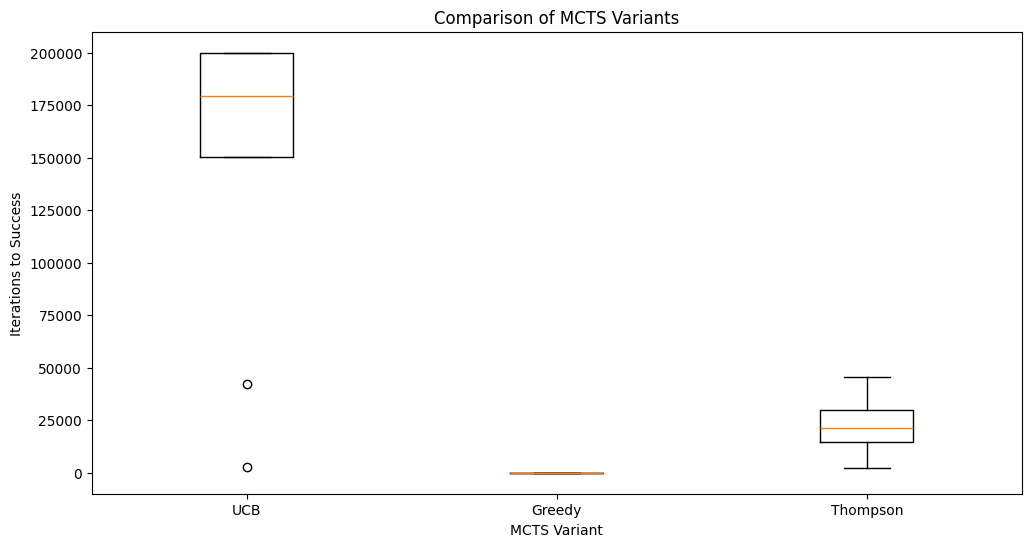

In [162]:
import matplotlib.pyplot as plt

# Create a list of results for boxplot
data = list(experiment_results.values())

plt.figure(figsize=(12, 6))
plt.boxplot(data, tick_labels=['UCB', 'Greedy', 'Thompson'])

plt.xlabel('MCTS Variant')
plt.ylabel('Iterations to Success')
plt.title('Comparison of MCTS Variants')
plt.show()


In [152]:
best_c = copy.deepcopy(root)
while best_c.children:
    print([c.actions[-1] for c in best_c.children])
    # print([c.value for c in best_c.children])
    # print([c.beta for c in best_c.children])
    print([c.visits for c in best_c.children])
    best_c = best_c.select_arm(greedy=True)
print(f"\nBest trajectory:{best_c.actions}\nScore: {get_t_value(best_c.actions)}")

['click(1008)', 'click(4351)', 'click(1039)', 'click(4351)', 'click(1062)', 'click(2135)', 'click(5432)', 'click(1113)', 'click(1136)', 'click(1209)']
[3690, 1172, 1163, 1163, 1130, 1186, 1170, 1170, 1179, 1186]
['click(1008)', 'click(4351)', 'click(1039)', 'click(4351)', 'click(1062)', 'click(2135)', 'click(5432)', 'click(1113)', 'click(1136)', 'click(1209)']
[309, 302, 881, 311, 312, 305, 323, 316, 317, 313]
['click(1008)', 'click(4351)', 'click(1039)', 'click(4351)', 'click(1062)', 'click(2135)', 'click(5432)', 'click(1113)', 'click(1136)', 'click(1209)']
[79, 74, 84, 73, 176, 80, 82, 76, 78, 78]
['click(1008)', 'click(4351)', 'click(1039)', 'click(4351)', 'click(1062)', 'click(2135)', 'click(5432)', 'click(1113)', 'click(1136)', 'click(1209)']
[13, 16, 15, 16, 14, 17, 19, 32, 17, 16]
['click(1008)', 'click(4351)', 'click(1039)', 'click(4351)', 'click(1062)', 'click(2135)', 'click(5432)', 'click(1113)', 'click(1136)', 'click(1209)']
[3, 3, 2, 3, 3, 3, 3, 3, 5, 3]
['click(1008)', 'cl